# Apache Kafka Streaming Analytics
### Two Broker Setup
<br>
<hr>

#### Component: Consumer Nr. 2
In this notebook Apache Kafka is going to be used and analyzed with reference to the streaming performance using the twitter dataset.

In this case, we are going to use two **Kafka Brokers** that streams the data to the **Kafka Consumers**.

In [ ]:
# Install the Python Client for Apache Kafka
!pip install confluent-kafka

In [1]:
# Load dependencies and set constants
import matplotlib.pyplot as plt
import platform, socket, json, psutil, logging, multiprocessing

from time import time, perf_counter
from confluent_kafka import Consumer, KafkaError
from statistics import mean
from datetime import datetime


DATASET_SIZE_IN_MB = 10
DATASET_SIZE_IN_MSGS = 14485

CONSUMER_GROUP_ID = "twitter-consumers"
KAFKA_TOPIC_TWITTER = "twitter-stream"

def get_system_info():
    """ Returns system information as JSON. """
    try:
        info = {}
        info['platform'] = platform.system()
        info['platform-version'] = platform.version()
        info['hostname'] = socket.gethostname()
        info['ram'] = str(round(psutil.virtual_memory().total / (1024.0 **3))) + " GB"
        info['vCPUs'] = multiprocessing.cpu_count()
        info['architecture'] = platform.machine()

        return json.dumps(info, indent=4)
    except Exception as e:
        logging.exception(e)
        
def assignment_report(consumer: Consumer, assignments: list):
    """ Callback for printing the assigned topic partitions of the consumer """
    for assignment in assignments:
        print("Consumer got assigned partition {0} for topic {1}.".format(assignment.partition, assignment.topic))
    print("\n")

### Reminder: Running Kafka Architecture required
The following cells assume a running Apache Kafka Environment.
<hr>
<br>

Furthermore, as we are using the **Consumer** component here, we have to make sure to start the consumer first before we start the Producer to ensure a performance measurement under realistic circumstances.

In [2]:
# Print system information
print(get_system_info())

# Create Kafka Consumer
consumer_config = {
    "bootstrap.servers": "localhost:9092",
    "group.id": CONSUMER_GROUP_ID,
    "client.id": "client-2",
    "enable.auto.commit": True,
    "session.timeout.ms": 6000,
    "default.topic.config": {"auto.offset.reset": "smallest"}
}
c = Consumer(consumer_config)

{
    "platform": "Linux",
    "platform-version": "#80-Ubuntu SMP Mon Apr 12 17:35:00 UTC 2021",
    "hostname": "kafka-worker",
    "ram": "18 GB",
    "vCPUs": 4,
    "architecture": "x86_64"
}


In [3]:
def visualize_results(latency_results: list, throughputs_mbs_per_sec:list, throughputs_msgs_per_sec: list, mb_per_exec: int):
    """ Visualizes the benchmark results in plots.
    
    :param latency_results: list of lists, each containing the latencies of a specific benchmark execution
    :param throughputs_mbs_per_sec: Throughput results, given in MBs / second
    :param throughputs_msgs_per_sec: Throughput results, given in Messages / second
    :param mb_per_exec: Amount of data in MB received per execution
    """
    # Latencies - per message
    for exec_count, latencies in enumerate(latency_results):
        fig = plt.figure(figsize=(10, 5), dpi=80)
        ax = plt.axes()
        
        ax.plot([i for i in range(len(latencies))], latencies)
        ax.set_ylabel("Latency (ms)")
        ax.set_title("Benchmark {0}: Latencies ({1} MB)".format(exec_count+1, mb_per_exec), fontsize=15)
        plt.tick_params(labelleft=True, labelbottom=False)
        plt.show()
    
    # Latencies - percentiles
    total_latencies = []
    for subresult in latency_results:
        total_latencies.extend(subresult)
        
    total_latencies.sort()
        
    p50_idx = int(len(total_latencies) * 50.0 / 100.0)
    p75_idx = int(len(total_latencies) * 75.0 / 100.0)
    p90_idx = int(len(total_latencies) * 90.0 / 100.0)
    p95_idx = int(len(total_latencies) * 95.0 / 100.0)
    p99_idx = int(len(total_latencies) * 99.0 / 100.0)
        
    p50 = total_latencies[p50_idx]
    p75 = total_latencies[p75_idx]
    p90 = total_latencies[p90_idx]
    p95 = total_latencies[p95_idx]
    p99 = total_latencies[p99_idx]
    
    print("============ Latency Results ============")
    print("| 50%: {0} | 75%: {1} | 90%: {2} | 95%: {3} | 99%: {4}\n"
          .format(p50, p75, p90, p95, p99))
    
    fig = plt.figure(figsize=(12, 6), dpi=90)
    ax = plt.axes()
        
    # Plot the ascendingly sorted latencies
    xs = [i for i in range(1, len(total_latencies)+1)]
    ys = total_latencies
    ax.plot(xs, ys)
        
    # Set Percentile labels and visualize them by dashed lines
    ax.set_xticks([p50_idx, p75_idx, p90_idx, p95_idx, p99_idx])
    ax.set_xticklabels(["50%", "75%", "90%", "95%", "99%"])
    ax.grid(axis="x", color="green", alpha=.4, linewidth=2, linestyle=":")
        
    ax.set_ylabel("Latency (ms)", fontsize=12)
    ax.set_title("Benchmark {0}: Latencies ({1} MB) - Percentiles".format(exec_count+1, mb_per_exec), fontsize=15)
        
    fig.show()
        
    # Min, Max, Avg MB/s and Messages/s
    max_mbs_per_sec, min_mbs_per_sec, avg_mbs_per_sec = max(throughputs_mbs_per_sec), \
                                                        min(throughputs_mbs_per_sec), \
                                                        mean(throughputs_mbs_per_sec)
    
    max_msgs_per_sec, min_msgs_per_sec, avg_msgs_per_sec = max(throughputs_msgs_per_sec), \
                                                           min(throughputs_msgs_per_sec), \
                                                           mean(throughputs_msgs_per_sec)
    
    print("============ Throughput Results ============")
    print("MB/s: | Max: {0} MB/s | Min: {1} MB/s | Avg: {2} MB/s"
          .format(max_mbs_per_sec, min_mbs_per_sec, avg_mbs_per_sec))
    
    print("Messages/s: | Max: {0} Messages/s | Min: {1} Messages/s | Avg: {2} Messages/s"
          .format(max_msgs_per_sec, min_msgs_per_sec, avg_msgs_per_sec))

    # Plot Max, Min, Avg MB/s
    fig = plt.figure(figsize=(10, 6), dpi=80)
    plt.bar(0, max_mbs_per_sec, width=1, color='navy')
    plt.bar(1, avg_mbs_per_sec, width=1, color='darkcyan')
    plt.bar(2, min_mbs_per_sec, width=1, color='skyblue')

    plt.tick_params(labelleft=True, labelbottom=False)
    plt.legend(["Maximum MB/s", "Average MB/s", "Minimum MB/s"], prop = {'size': 12}, bbox_to_anchor=(1.05, 0.8))
    plt.title("Summarization of Throughput in MB/s", fontsize=14, pad=12)
    plt.show() 
    
    # Plot Max, Min, Avg Messages/s
    fig = plt.figure(figsize=(10, 6), dpi=80)
    plt.bar(0, max_msgs_per_sec, width=1, color='navy')
    plt.bar(1, avg_msgs_per_sec, width=1, color='darkcyan')
    plt.bar(2, min_msgs_per_sec, width=1, color='skyblue')

    plt.tick_params(labelleft=True, labelbottom=False)
    plt.legend(["Maximum MSG/s", "Average MSG/s", "Minimum MSG/s"], prop = {'size': 12}, bbox_to_anchor=(1.05, 0.8))
    plt.title("Summarization of Throughput in Messages/s", fontsize=14, pad=12)
    plt.show()

def benchmark(mb_per_exec: int = 1000, exec_count: int = 10):
    """ Executes a latency benchmark procedure, e.g. the elapsed time between storing 
        a message in the logs at the Broker side (LogAppendTime) and receiving / consuming it 
        on the Consumer side. To get meaningful results, the benchmark procedure is repeated
        exec_count times.
        Default is ~ 1GB per execution, while executing 10 times.

        :param mb_per_exec: Amount of data to expect (sent by the producer) per execution, given in MB.
                            As the dataset is 10 MB large, mb_per_exec % 10 = 0 should be true for the
                            given argument.
        :param exec_count: Amount of times to repeat the benchmark procedure
    """
    print("Executing latency benchmark. Waiting for Producer sending data ...")        
    
    latency_results = []
    throughputs_in_mb = [] # MB/s
    throughputs_in_msgs = [] # Messages/s
    
    total_messages = int(DATASET_SIZE_IN_MSGS * (mb_per_exec / DATASET_SIZE_IN_MB))
        
    c.subscribe([KAFKA_TOPIC_TWITTER], on_assign=assignment_report)
    for execution in range(exec_count):
        msg_counter = 0
        latencies = []
        
        start = None
        while msg_counter < total_messages:               
            msg = c.poll(0.5)

            if msg is None:
                continue
            elif not msg.error():
                msg_counter += 1
                
                # Start the timer once the first message was received
                if msg_counter == 1:
                    start = perf_counter()
                    print("Starting consuming: {}".format(datetime.utcnow().isoformat(sep=' ', timespec='milliseconds')))

                latency = (time() * 1000) - msg.timestamp()[1]
                latencies.append(latency)
            elif msg.error().code() == KafkaError._PARTITION_EOF:
                print("End of partition reached {}/{}".format(msg.topic(), msg.partition()))
                print("Messages consumed: {}".format(msg_counter))
            else:
                print("Error occured: {}".format(msg.error().str()))
        end = perf_counter()
        print("Stopping consuming: {}".format(datetime.utcnow().isoformat(sep=' ', timespec='milliseconds')))
        
        consume_time = float(end - start)
        megabytes_per_second = mb_per_exec / consume_time
        msgs_per_second = total_messages / consume_time
        
        print("{} Messages in {:.2f} seconds | {} Messages/s"
              .format(total_messages, consume_time, int(total_messages / consume_time)))
        print("\n")
        
        # Save results for later visualization
        latency_results.append(latencies)
        throughputs_in_mb.append(megabytes_per_second)
        throughputs_in_msgs.append(msgs_per_second)
        
    c.close()
    
    print("\n" + "Benchmark procedure finished. Visualizing the results ...")
    visualize_results(latency_results, throughputs_in_mb, throughputs_in_msgs, mb_per_exec)

Executing latency benchmark. Waiting for Producer sending data ...
Consumer got assigned partition 1 for topic twitter-stream.


Starting consuming: 2021-04-27 12:28:01.987
Stopping consuming: 2021-04-27 12:28:14.568
1448500 Messages in 12.58 seconds | 115135 Messages/s


Starting consuming: 2021-04-27 12:28:14.569
Stopping consuming: 2021-04-27 12:28:25.357
1448500 Messages in 10.79 seconds | 134269 Messages/s


Starting consuming: 2021-04-27 12:28:25.362
Stopping consuming: 2021-04-27 12:28:36.022
1448500 Messages in 10.66 seconds | 135878 Messages/s


Starting consuming: 2021-04-27 12:28:36.027
Stopping consuming: 2021-04-27 12:28:46.394
1448500 Messages in 10.37 seconds | 139724 Messages/s


Starting consuming: 2021-04-27 12:28:46.396
Stopping consuming: 2021-04-27 12:28:57.690
1448500 Messages in 11.29 seconds | 128253 Messages/s


Starting consuming: 2021-04-27 12:28:57.692
Stopping consuming: 2021-04-27 12:29:08.676
1448500 Messages in 10.98 seconds | 131884 Messages/s


Startin

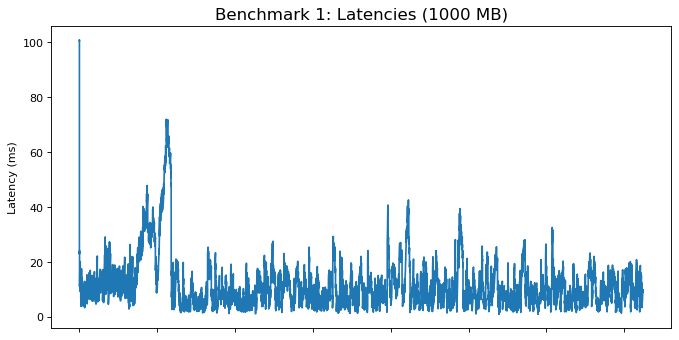

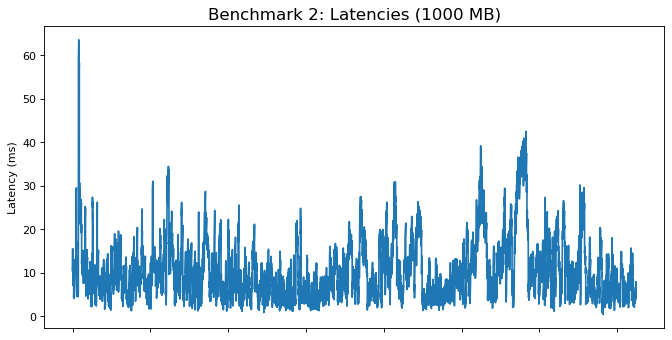

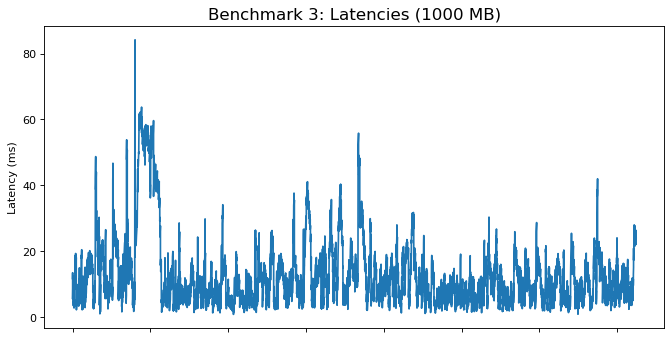

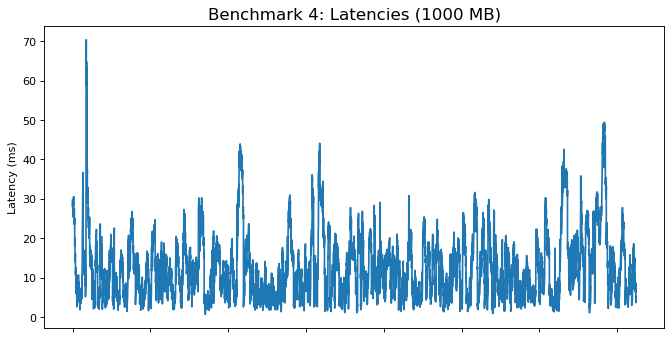

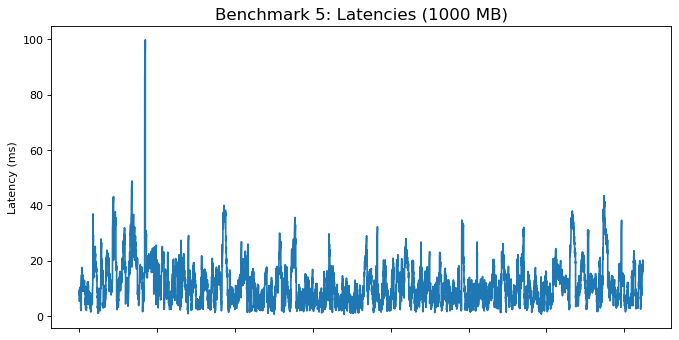

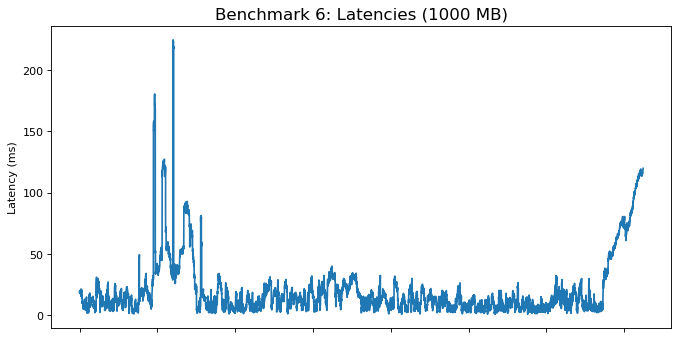

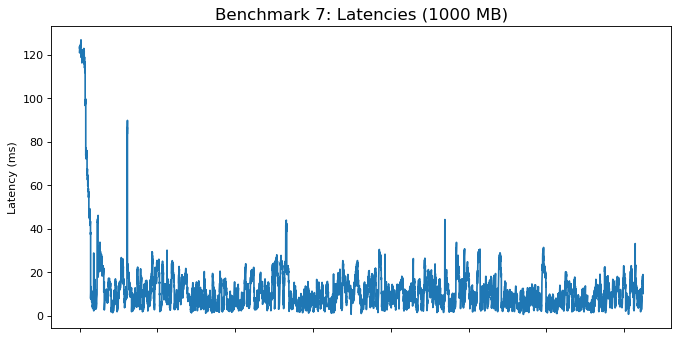

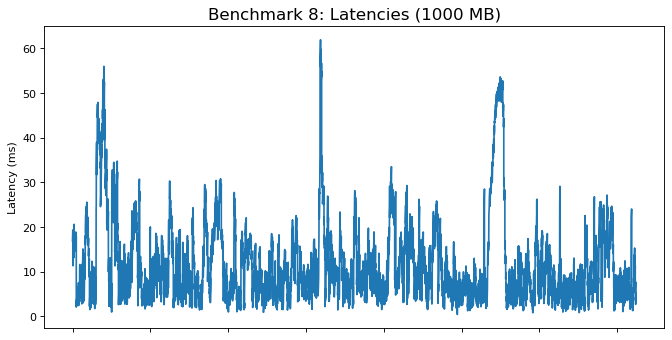

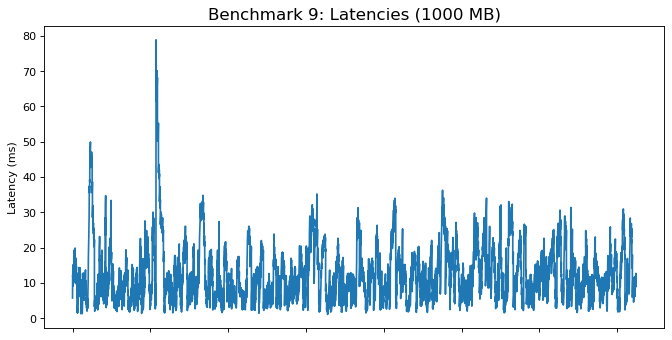

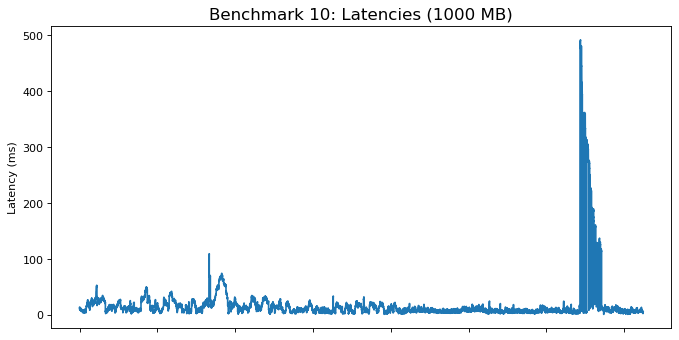

============ Latency Results ============
| 50%: 9.790283203125 | 75%: 15.62744140625 | 90%: 23.77587890625 | 95%: 31.333740234375 | 99%: 72.8671875

============ Throughput Results ============
MB/s: | Max: 96.461684392152 MB/s | Min: 75.81666418703722 MB/s | Avg: 89.11751280053953 MB/s
Messages/s: | Max: 139724.74984203218 Messages/s | Min: 109820.43807492341 Messages/s | Avg: 129086.71729158152 Messages/s


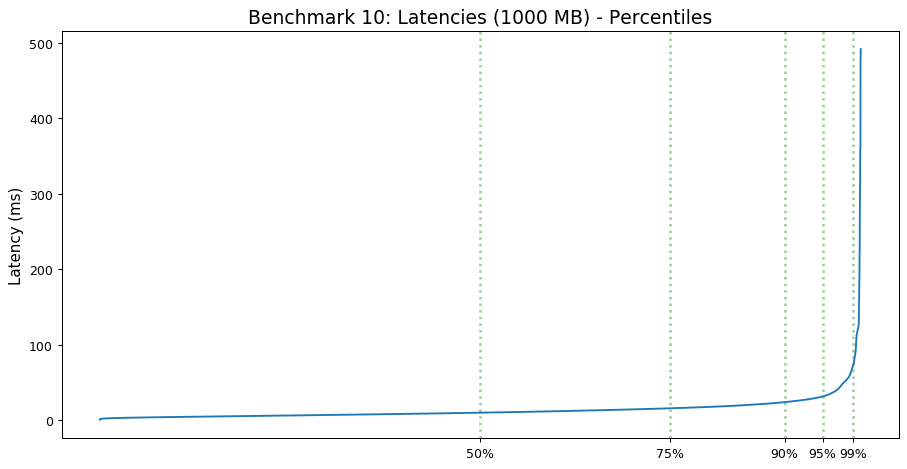

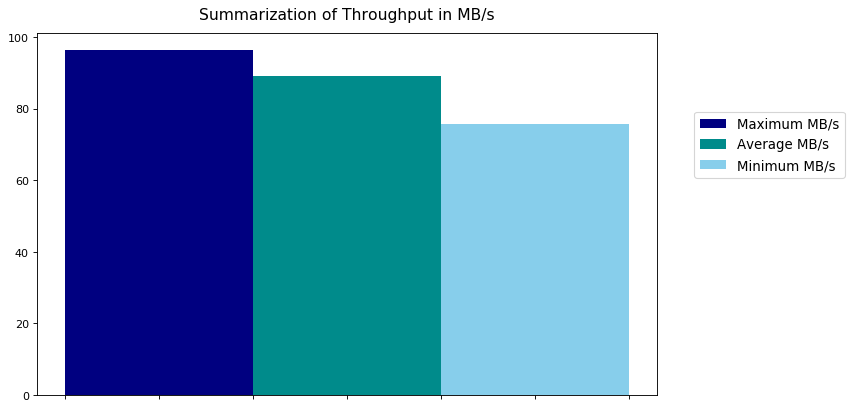

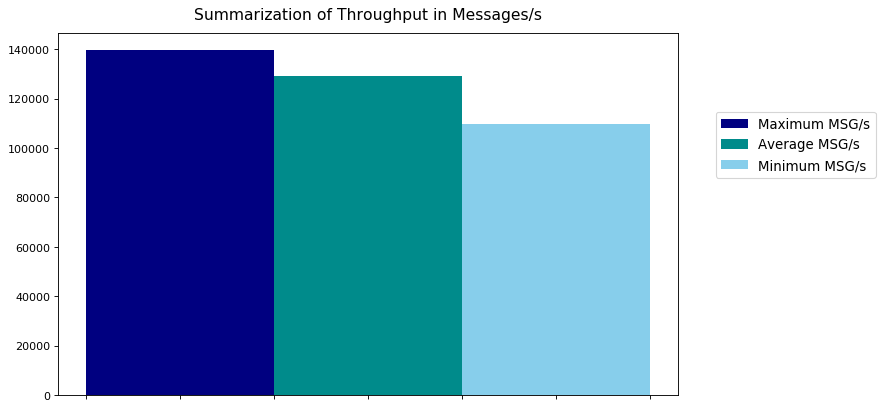

In [4]:
# Execute the benchmark
benchmark(mb_per_exec=1000, exec_count=10)